In [1]:
import numpy as np
import os
import os.path as osp
import pickle
import matplotlib.pyplot as plt

In [2]:
# root="/home/wzy/segment-anything/data/source_data4/scan_gradB/fc128"

# chor_lis=np.loadtxt(osp.join(root,"chorus.out"))
# # chor_lis=chor_lis.reshape(1002,1000,2).transpose(1,0,2)
# chor_lis=chor_lis.reshape(1000,502,2)
# print(chor_lis.shape)

# zpos_lis=np.loadtxt(osp.join(root,"zpos.out"))
# print(zpos_lis.shape)
# sour_lis=np.loadtxt(osp.join(root,"source.out"))
# sour_lis=sour_lis.reshape(1000,502,2)
# print(sour_lis.shape)

In [3]:
# 第一组数据
chor_lis=np.load("/home/wzy/segment-anything/data/chor.npy")
print(chor_lis.shape)
alpha_lis=np.load("/home/wzy/segment-anything/data/alpha.npy")
print(alpha_lis.shape)
sour_lis=np.load("/home/wzy/segment-anything/data/sour.npy")
print(sour_lis.shape)
vg_lis=np.load("/home/wzy/segment-anything/data/vg.npy")
print(vg_lis.shape)
vg_lis=np.load("/home/wzy/segment-anything/data/vg.npy")
print(vg_lis.shape)
zpos_lis=np.load("/home/wzy/segment-anything/data/zpos.npy")
print(zpos_lis.shape)

(1000, 1002, 2)
(1000, 1000)
(1000, 1002, 2)
(1001,)
(1001,)
(1001,)


In [4]:
import numpy as np
from numpy.linalg import lstsq

def _fit(x:np.ndarray,y:np.ndarray,z:np.ndarray):
    """
    y=a;x=da/ds
    z=ar*(xr+ixi)+(br+ibi)(yr+iyi)
    """
    z_real=z.real
    z_imag=z.imag
    X_real = np.column_stack((x.real,y.real,y.imag))
    X_imag=np.column_stack((x.imag,y.real,y.imag))

    # 使用最小二乘法求解参数
    #ar, br, -bi
    coefficients1, residuals, rank, singular_values = lstsq(X_real, z_real, rcond=None)

    # ar, bi, br
    coefficients2, residuals, rank, singular_values = lstsq(X_imag, z_imag, rcond=None)
    return coefficients1,coefficients2

In [5]:
chor_lis.shape

(1000, 1002, 2)

In [6]:
zpos_lis.shape

(1001,)

In [11]:
def fit(time,cut=(0,-1),show=False):
    chor_lis2=chor_lis[time,:,0]+1j*chor_lis[time,:,1]
    sour_lis2=sour_lis[time,:,0]+1j*sour_lis[time,:,1]
    delta_chor=chor_lis2[1:]=chor_lis2[:-1]
    delta_s=zpos_lis[1:]-zpos_lis[:-1]
    partial_chor_lis=delta_chor[:-1]/delta_s*1e7
    chor_lis2=chor_lis2[1:-1]*1e7
    sour_lis2=sour_lis2[1:-1]*1e7
    assert np.array(chor_lis2).shape==np.array(sour_lis2).shape==np.array(partial_chor_lis).shape

    x_data=chor_lis2[cut[0]:cut[1]]
    y_data=partial_chor_lis[cut[0]:cut[1]]
    z_data=sour_lis2[cut[0]:cut[1]]
    
    result=_fit(x_data,y_data,z_data)
    # print(result)
    br=(result[0][1]+result[1][2])*0.5
    bi=(-1*result[0][2]+result[1][1])*0.5
    ar=(result[0][0]+result[1][0])*0.5
    
    # params_fit=result.x
    # success=result.success
    # a_real, a_imag, b_real, b_imag = params_fit
    z_fit=ar*x_data+(br+1j*bi)*y_data

    if show:
        zpos=zpos_lis[:-1]
        zpos=zpos[cut[0]:cut[1]]
        plt.plot(zpos,np.real(z_data))
        plt.plot(zpos,np.real(z_fit))
        plt.title("Real")
        plt.xlabel("s")
        plt.ylabel("J")
        plt.legend(["origin J","predict J"])
        plt.show()
        plt.plot(np.imag(z_data))
        plt.plot(np.imag(z_fit))
        plt.title("Imag")
        plt.legend(["origin J","predict J"])
        plt.xlabel("s")
        plt.ylabel("J")
        plt.show()
    return ar,br+1j*bi,z_fit


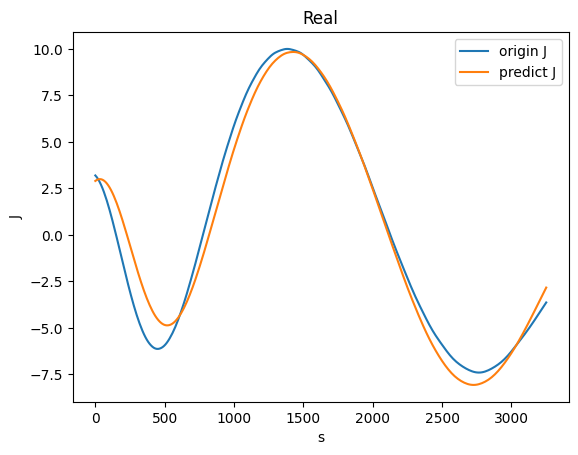

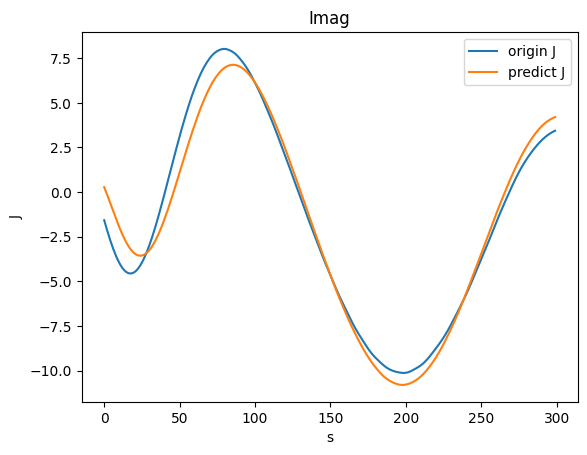

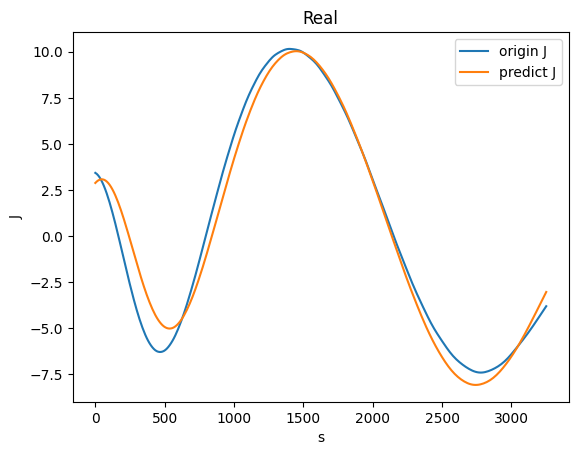

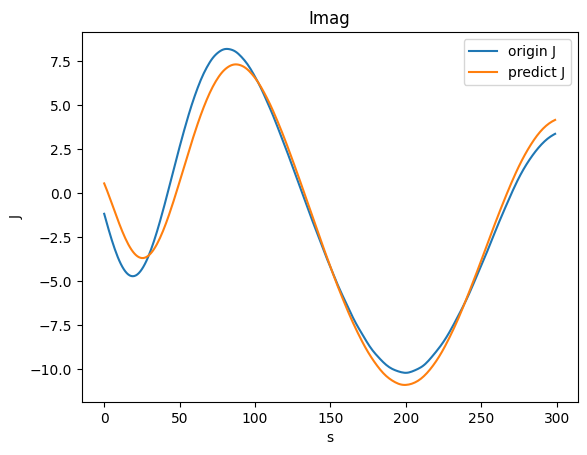

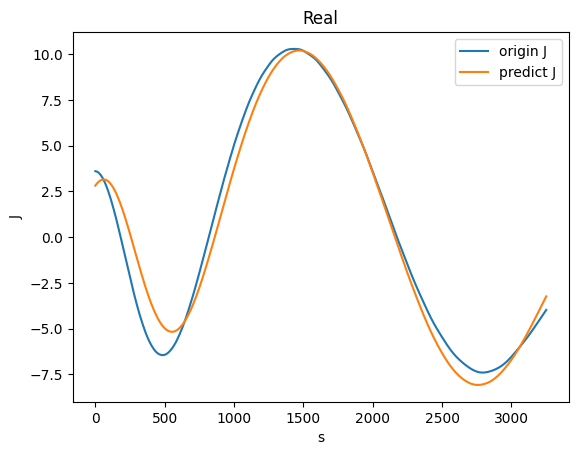

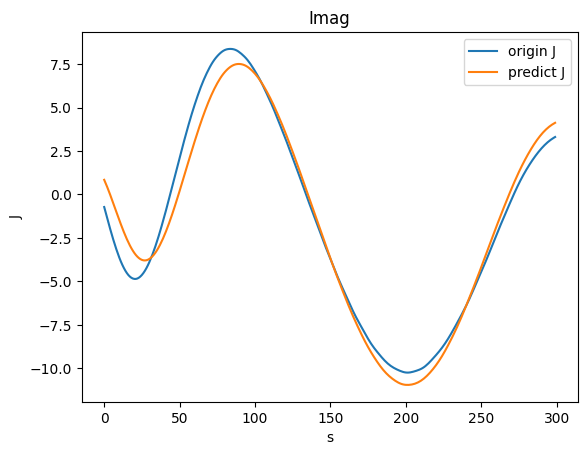

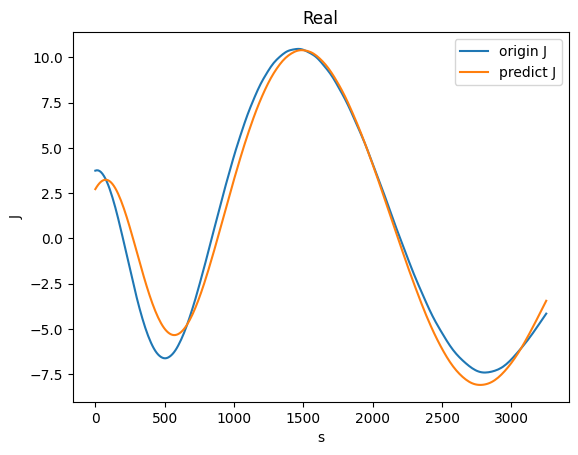

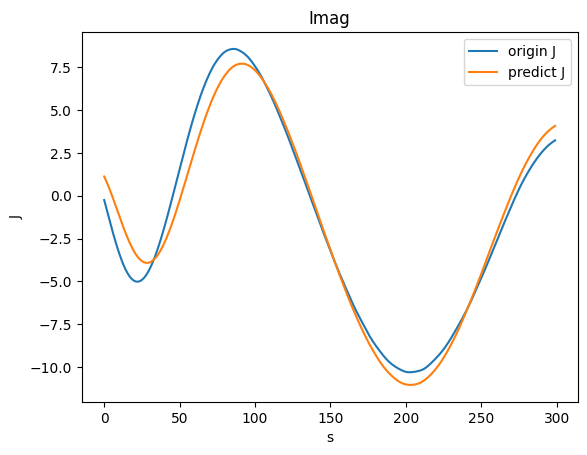

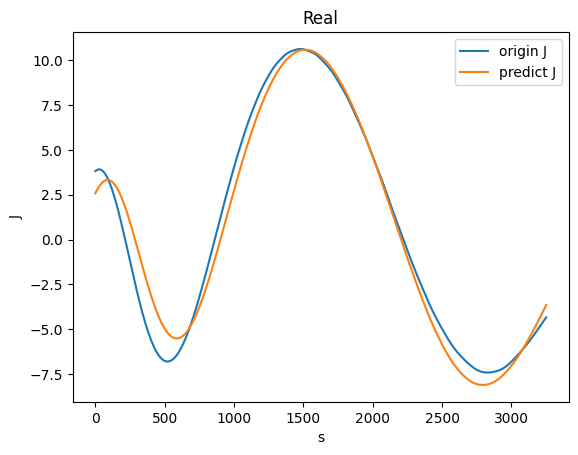

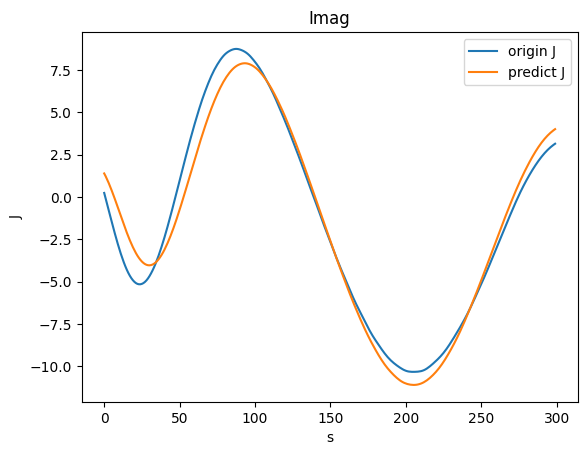

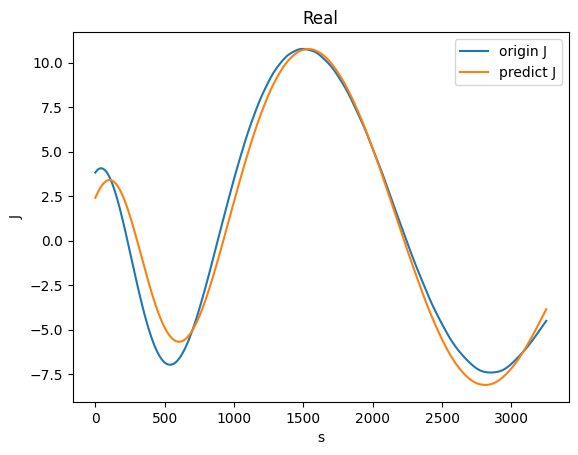

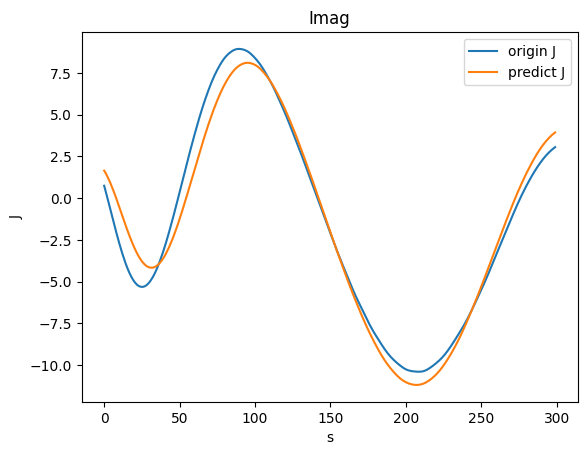

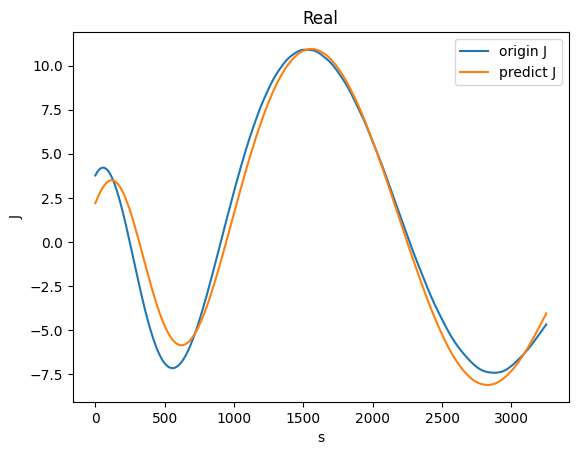

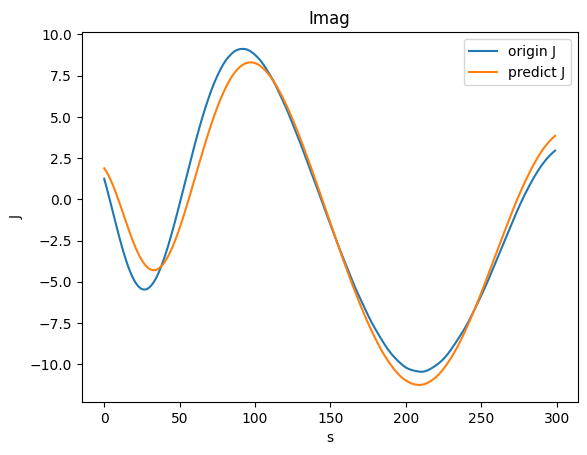

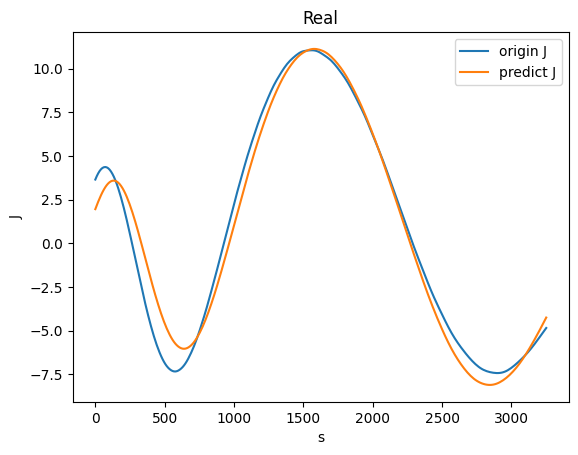

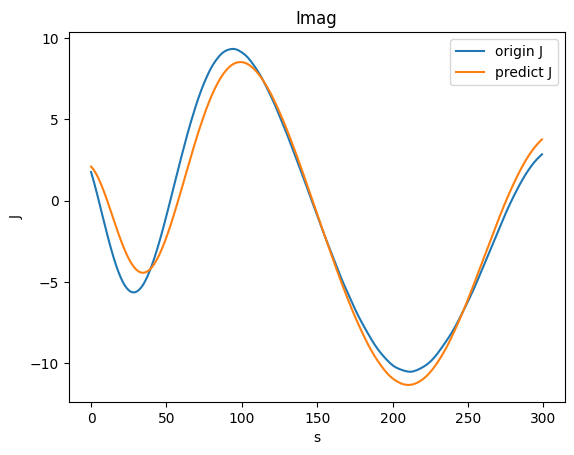

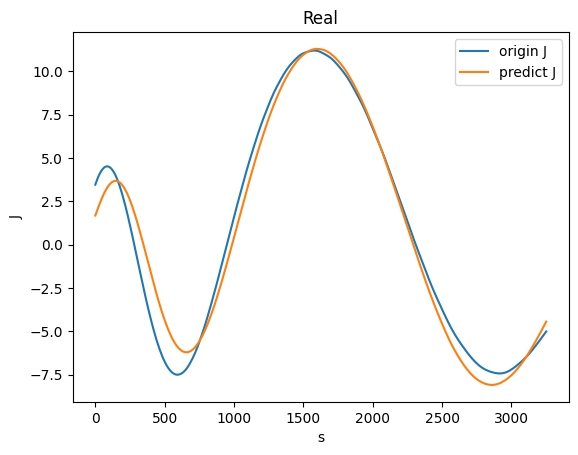

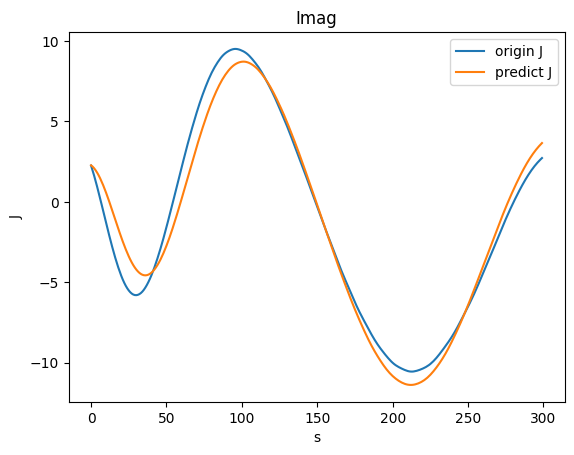

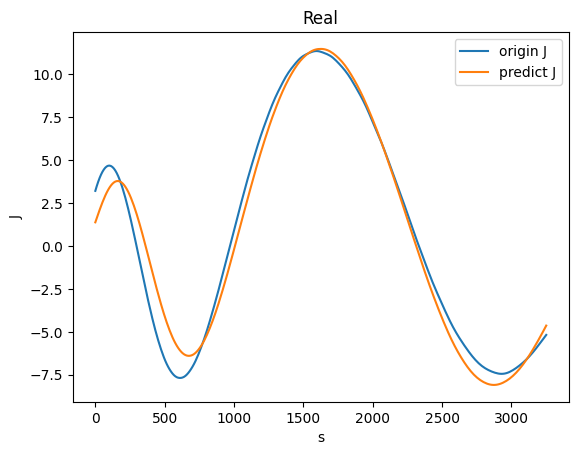

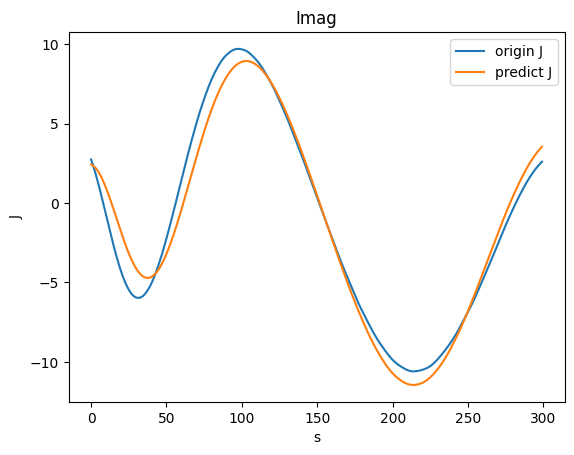

In [12]:
a_lis=[]
b_lis=[]
cut=(500,800)
time_lis=list(range(800,810))
for time in time_lis:
    # print(time)
    a,b,z=fit(time,cut=cut,show=True)
    a_lis.append(a)
    b_lis.append(b)
    # ok_lis.append(ok)

a_lis,b_lis=np.array(a_lis),np.array(b_lis)

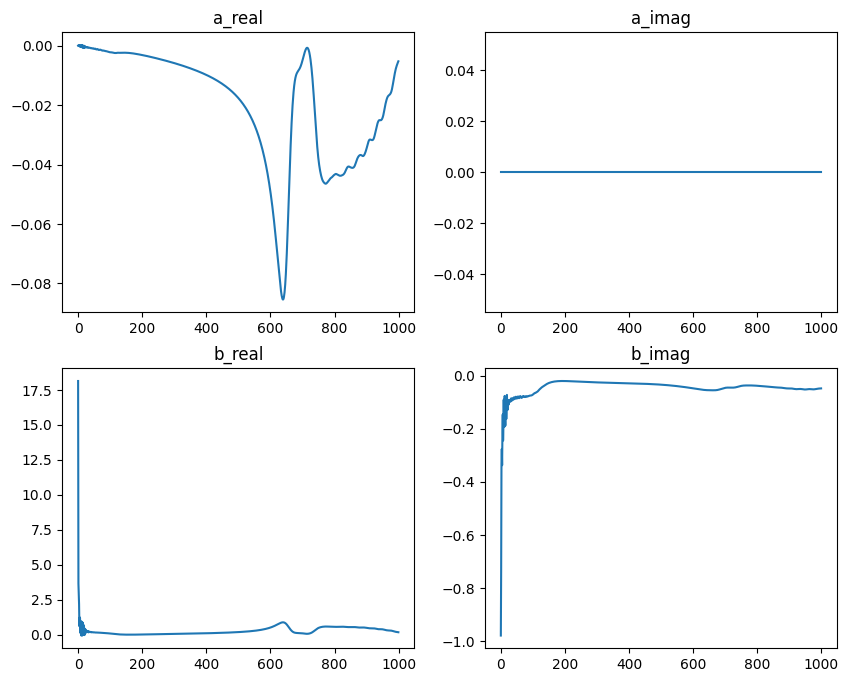

In [10]:
fig,axs=plt.subplots(2,2,figsize=(10,8))

axs[0,0].plot(time_lis,a_lis.real)
axs[0,0].set_title("a_real")
axs[0,1].plot(time_lis,a_lis.imag)
axs[0,1].set_title("a_imag")
axs[1,0].plot(time_lis,b_lis.real)
axs[1,0].set_title("b_real")
axs[1,1].plot(time_lis,b_lis.imag)
axs[1,1].set_title("b_imag")
# plt.suptitle(f"initial_guess={initial_guess}")
plt.show()


In [11]:
vg_lis[None,:].shape

(1, 1001)

In [12]:
chor_lis2=chor_lis[:,:,0]+1j*chor_lis[:,:,1]
phi_lis=np.angle(chor_lis2)[time_lis[0]:time_lis[-1]+1,:]
delta_phi=phi_lis[:,1:]-phi_lis[:,:-1]
delta_s=zpos_lis[1:]-zpos_lis[:-1]
partial_phi_lis=delta_phi[:,:-1]/delta_s

v_lis=np.repeat(vg_lis[None,:],b_lis.shape[0],axis=0)

In [13]:
# 增长率 r=ar-bi*(dphi/ds)
gamma=a_lis.real[:,None]-b_lis.imag[:,None]*partial_phi_lis
# 新波速 v'=v-br
v2=v_lis-b_lis.imag[:,None]

In [14]:
time

999

In [15]:
a,b=zip(*[(1,2),(3,4)])

Text(0, 0.5, 'gamma')

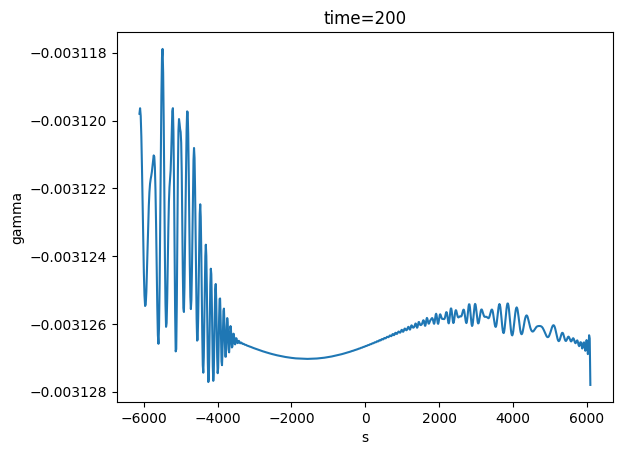

In [16]:
time=200
zero=gamma[time-time_lis[0],0]
x,y=zip(*tuple(filter(lambda x : np.abs(x[1]-zero)<0.02, zip(zpos_lis[:-1],gamma[time-time_lis[0],:]))))
plt.plot(x,y)
plt.title(f"time={time}")
plt.xlabel("s")
plt.ylabel("gamma")

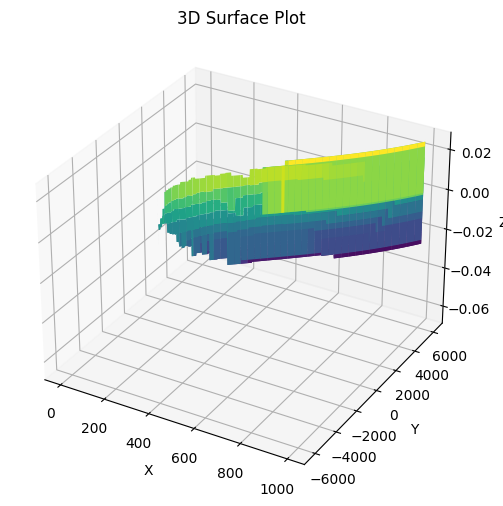

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# 创建数据
gamma2=np.zeros_like(gamma)
for i in range(gamma.shape[0]):
    for j in range(gamma.shape[1]):
        if np.abs(gamma[i,j]-gamma[i,0])>0.02:
            gamma2[i,j]=gamma[i,j]
        else:
            gamma2[i,j]=gamma2[i,j-1]
x = time_lis
y = zpos_lis[:-1]
z = gamma2


# 绘制三维图像
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='viridis')

# 设置坐标轴标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 设置图像标题
plt.title('3D Surface Plot')

plt.show()


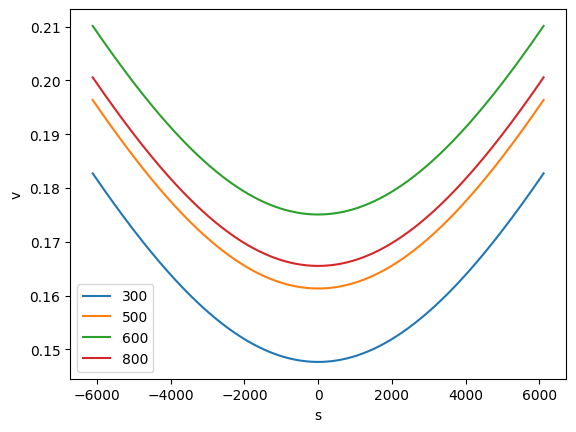

In [18]:
for time in [200,500,600,800]:
    plt.plot(zpos_lis,v2[time-time_lis[0],:])
    plt.ylabel("v")
    plt.xlabel("s")
plt.legend([300,500,600,800])

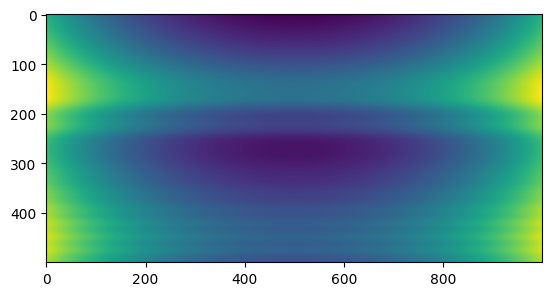

In [19]:
plt.imshow(v2[500:1000,0:1000])

In [20]:
zpos_lis[500:-1]

array([   0.        ,   10.28379193,   20.56762041,   30.851522  ,
         41.13553326,   51.41969074,   61.70403099,   71.9885906 ,
         82.27340611,   92.55851411,  102.84395117,  113.12975387,
        123.4159588 ,  133.70260255,  143.98972173,  154.27735294,
        164.56553282,  174.85429797,  185.14368505,  195.4337307 ,
        205.72447159,  216.01594438,  226.30818576,  236.60123242,
        246.89512108,  257.18988847,  267.48557132,  277.7822064 ,
        288.07983046,  298.37848031,  308.67819275,  318.97900461,
        329.28095272,  339.58407396,  349.8884052 ,  360.19398335,
        370.50084534,  380.8090281 ,  391.11856862,  401.42950388,
        411.74187091,  422.05570673,  432.37104842,  442.68793308,
        453.00639781,  463.32647977,  473.64821612,  483.97164407,
        494.29680086,  504.62372373,  514.95244999,  525.28301695,
        535.61546196,  545.94982241,  556.28613572,  566.62443935,
        576.96477077,  587.3071675 ,  597.65166711,  607.99830

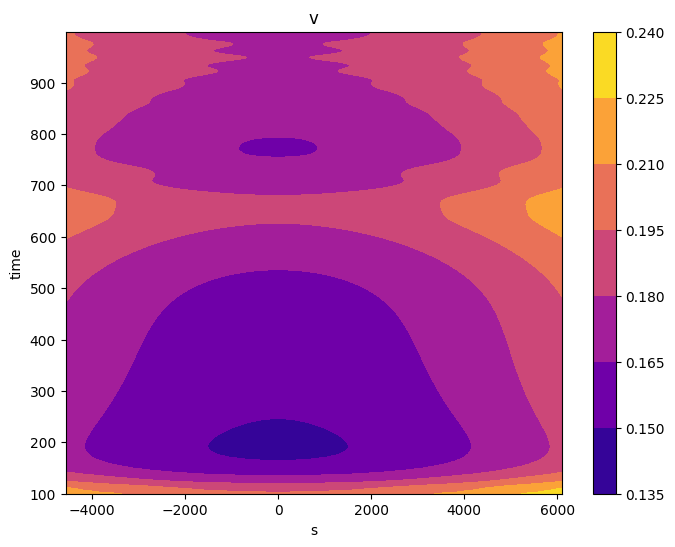

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# 创建数据
x = time_lis[100:]
y = zpos_lis[100:-1]
x,y=y,x
z = v2[100:,100:-1]

# 绘制colormap
plt.figure(figsize=(8, 6))
plt.contourf(x, y, z, cmap='plasma')  # 这里使用 'plasma' colormap，你可以替换成其他的colormap名称
plt.colorbar()  # 添加colorbar
plt.title('v')
plt.xlabel('s')
plt.ylabel('time')
plt.show()

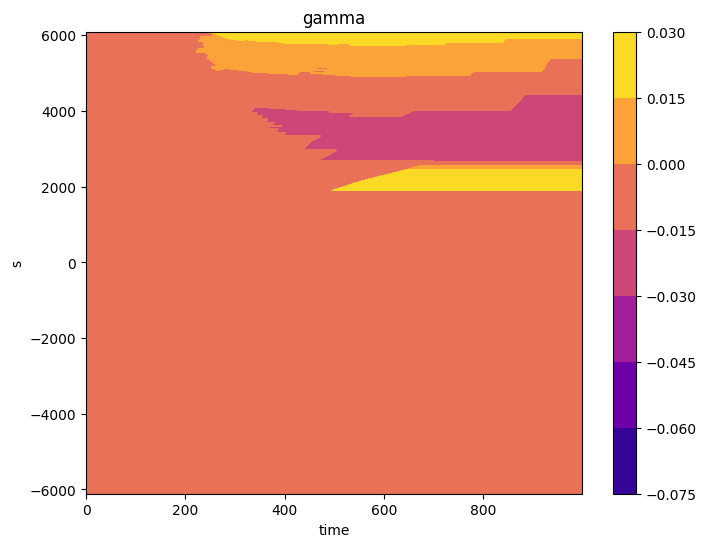

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# 创建数据
x = time_lis
y = zpos_lis[:-1]
z = gamma2

# 绘制colormap
plt.figure(figsize=(8, 6))
plt.contourf(x, y, z, cmap='plasma')  # 这里使用 'plasma' colormap，你可以替换成其他的colormap名称
plt.colorbar()  # 添加colorbar
plt.title('gamma')
plt.xlabel('time')
plt.ylabel('s')
plt.show()


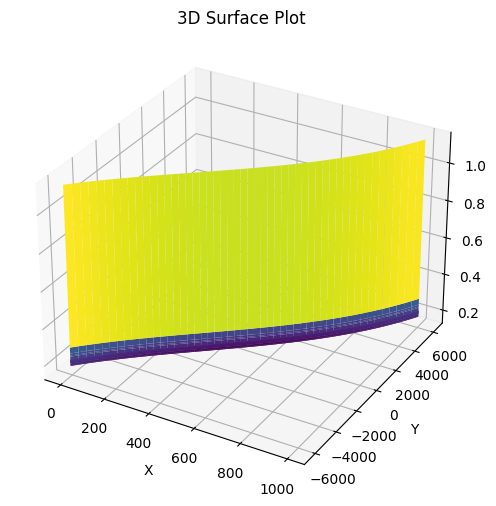

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# 创建数据
gamma2=np.zeros_like(gamma)
for i in range(gamma.shape[0]):
    for j in range(gamma.shape[1]):
        if np.abs(gamma[i,j]-gamma[i,0])>0.02:
            gamma2[i,j]=gamma[i,j]
        else:
            gamma2[i,j]=gamma2[i,j-1]
x = time_lis
y = zpos_lis[:-1]
z = v2[:,:-1]


# 绘制三维图像
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='viridis')

# 设置坐标轴标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 设置图像标题
plt.title('3D Surface Plot')

plt.show()
